# Capstone Project - Exploring Social Disparities across Neighborhoods in Chicago
Applied Data Science Capstone by IBM/Coursera - Jun 2021 by Junjun Zheng

## INTRODUCTION
Urban areas would accommodate over 70% world population by 2050. Modern cities are organized to effectively build out civic infrastructure and efficiently deliver necessary public services. However, there are growing concerns of social inequality that urban residents may have inequitable access to infrastructure and services depending on where they live. 

Social injustice results in imbalanced economic development and contributes to gaps in quality of life across urban neighborhoods. Yet, despite increasing awareness toward social inequity, quantitative assessments for such social disparities are still lagging. This situation becomes the barrier to sustainable development, and inadequate understanding of the underlying conditions hinders strategic urban planning for potential implications.

This study deploys data science toolkits to explore social disparities across neighborhoods. The study develops a novel framework by integrating diverse analytic approaches. The numerical analysis quantifies the relationship among various neighborhood characteristics, including household income, spatial clusters, and land uses. Therefore, this study bridges the neighborhood’s socioeconomic factors with the infrastructure and built environments, aiming to provide nuances to equitable community investment and place-based development initiatives.


## DATA AND METHODS
The numerical analysis takes the city of Chicago as the case study area. Chicago consists of 56 zip codes (neighborhoods), which is the unit of analysis in this study. Based on the existing projects and studies, the zip code is one of the best scales to analyze the spatial heterogeneities within a city.    

### Data Acquisition and Cleaning
By looking at zip codes, this study collects data from diverse sources. The base map consists of the polygons of all Chicago zip codes in a shapefile . On the one hand, median household income (MHI of each zip code) is the proxy for socioeconomic factors. U.S. Census provides the data under American Community Survey (2019, 5-year estimates). 

On the other hand, Foursquare location data are collected for quantifying neighborhood land uses. First, all Chicago zip codes are indexed to their centroid based on the latitudes and longitudes of the polygons. Then, this study collects all venues within 800 meters of each neighborhood centroid by using Foursquare API, which results in 5,375 venues that meet the requirement. 

However, these over 5000 venues have 423 unique categories, which are too detailed to categorize neighborhood land-use patterns. For example, the restaurants and food-service outlets have been categorized into over 30 categories: American, Chinese, Japanese, etc. A data cleaning process is needed for further analysis. Hence, this study pulls out over 400 unique categories and crosswalks them to ten (10) major categories.
 
The crosswalk data (provided in data files) reduces the dimensions of the original dataset and helps improve the efficiency and accuracy of the analysis. 
Furthermore, over 5000 venues are aggregated into 56 zip codes by the ten business categories. This calculates the shares of each business category against total businesses for each zip code. For example, the “Offices” under the zip code “60610” is 0.5163, indicating 51.63% of businesses within this zip code are offices. As a result, the data consist of land use patterns for all Chicago zip codes.
Once all data are collected and cleaned, this study integrates a dataset by merging the socioeconomic variable with the land use data. The final dataset includes variables of geometries, median household income (MHI), and land use shares (for ten major categories).


In [1]:
# Import packages
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
# import requests
# from bs4 import BeautifulSoup

# Import geocoder for Question 2
import geocoder # import geocoder
import requests

# Data Analytics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# OPEN THE SHAPEFILE
path_geodata = "./Geodata/SimplyAnalytics_Shapefiles_2021-06-18_16_35_38_1aab3ecb451c42e3c3c94ea13da56031.shp"
file_geodata = gpd.read_file(path_geodata)

file_geodata.columns = ['SPATIAL_ID','NAME','INCOME','geometry']
# file_geodata

# Creat a list only in Chicago
zipcodes = []
for i in range(len(file_geodata)):
    # print(i)
    zpcd, city, stid = file_geodata.NAME[i].split(',',2)
    inc = round(file_geodata.INCOME[i],2)
    # print(city)
    row = [zpcd, city, stid, inc]
    if city in ' Chicago ':
        # print(zpcd)
        zipcodes.append(row)
# print(zipcodes)
df_zipcodes = pd.DataFrame(zipcodes)
df_zipcodes.columns = ['ZPCD','CITY','STATE','ZP_INC']
df_zipcodes.head(5)

,ZPCD,CITY,STATE,ZP_INC
0,60601,Chicago,IL,107195.42
1,60602,Chicago,IL,147682.05
2,60603,Chicago,IL,154786.84
3,60604,Chicago,IL,111927.92
4,60605,Chicago,IL,114545.59


In [3]:
# GENERATE THE CENTROIDS OF THE ZIPCODE
gdf_chicago = file_geodata.merge(df_zipcodes, left_on ='SPATIAL_ID', right_on = 'ZPCD')
# gdf_chicago

gdf_chicago['CENTROID'] = gdf_chicago['geometry'].centroid
# df['lon'] = df.point_object.x
# df['lat'] = df.point_object.y
gdf_chicago['X'] = gdf_chicago['CENTROID'].x
gdf_chicago['Y'] = gdf_chicago['CENTROID'].y
gdf_chicago.head(5)

<ipython-input-3-9234d4698b53>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_chicago['CENTROID'] = gdf_chicago['geometry'].centroid


,SPATIAL_ID,NAME,INCOME,geometry,ZPCD,CITY,STATE,ZP_INC,CENTROID,X,Y
0,60601,"60601, Chicago, IL",107195.418848,"POLYGON ((-87.63396 41.88698, -87.63373 41.886...",60601,Chicago,IL,107195.42,POINT (-87.62206 41.88529),-87.622064,41.885285
1,60602,"60602, Chicago, IL",147682.046803,"POLYGON ((-87.63389 41.88447, -87.63386 41.884...",60602,Chicago,IL,147682.05,POINT (-87.62915 41.88307),-87.629148,41.883073
2,60603,"60603, Chicago, IL",154786.835212,"POLYGON ((-87.63382 41.88195, -87.63379 41.881...",60603,Chicago,IL,154786.84,POINT (-87.62551 41.88019),-87.625510,41.880188
3,60604,"60604, Chicago, IL",111927.919708,"POLYGON ((-87.63376 41.87925, -87.63375 41.879...",60604,Chicago,IL,111927.92,POINT (-87.62846 41.87810),-87.628460,41.878095
4,60605,"60605, Chicago, IL",114545.586187,"MULTIPOLYGON (((-87.63312 41.87449, -87.63306 ...",60605,Chicago,IL,114545.59,POINT (-87.61682 41.86815),-87.616821,41.868150


In [4]:
# COLLECT DATA FROM FOURSQUARE

def VenuesDataCollection(zpcd_id, lng, lat):
    # lng = gdf_chicago.X[1]
    # lat = gdf_chicago.Y[1]
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        lat, lng,
        ACCESS_TOKEN, 
        VERSION, 
        # search_query, 
        radius, 
        LIMIT)
    # url
    results = requests.get(url).json()
    # results["response"]['venues']
    
    zpcd_venues = results["response"]['venues']
    categories = []
    
    for i in range(len(zpcd_venues)):
        # print(i)
        venue = zpcd_venues[i]['categories']
        if len(venue)>0:
            try:
                name = venue[0]['name']
            except:
                name = ''
            plural_name=venue[0]['pluralName']
            short_name =venue[0]['shortName']
            categories.append([zpcd_id, name, plural_name, short_name])
    
    return categories  

# Access to Foursquare Data
CLIENT_ID = 'EPLZVRBN41DTMMYN0DKIQ1QAWXUKJOI3A4PAN5DZPRT0GPR1' # your Foursquare ID
CLIENT_SECRET = 'GSV2JZGGLP2SA1F5APRDI4DOYSVSBVWYPO2ZEZPTE4MSOCBXX' # your Foursquare Secret
ACCESS_TOKEN = 'T0GCV0KOGM4BAZ0DN5ORUP0R4SVRSQEZ4ASBJZSRHFPJZFMN' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 300
radius = 800
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EPLZVRBN41DTMMYN0DKIQ1QAWXUKJOI3A4PAN5DZPRT0GPR1
CLIENT_SECRET:GSV2JZGGLP2SA1F5APRDI4DOYSVSBVWYPO2ZEZPTE4MSOCBXX


In [5]:
# DOWBLOADING DATA
req_dta = gdf_chicago[['SPATIAL_ID', 'X', 'Y']]
# req_dta
venue_results = []
for index, row in req_dta.iterrows():
    result = VenuesDataCollection(row[0],row[1], row[2])
    # print('Location:',row[0], row[1], row[2],'has', len(result),'venues')
    venue_results.extend(result)
# venue_results
print ('Completed.........')

Location: 60601 -87.62206357008972 41.88528523042665 has 123 venues
Location: 60602 -87.62914845044858 41.883072880939956 has 119 venues
Location: 60603 -87.62550976274478 41.88018799289934 has 113 venues
Location: 60604 -87.62845993974331 41.8780954997571 has 106 venues
Location: 60605 -87.61682112415419 41.86814991560412 has 48 venues
Location: 60606 -87.63735145603108 41.88207054633471 has 122 venues
Location: 60607 -87.65158943646624 41.87492495266917 has 104 venues
Location: 60608 -87.67139985218077 41.84874019295124 has 110 venues
Location: 60609 -87.65564454854443 41.812505891490524 has 113 venues
Location: 60610 -87.63204061838475 41.90697023524323 has 94 venues
Location: 60611 -87.6142610872995 41.893852146226024 has 39 venues
Location: 60612 -87.68774265080441 41.88031290649718 has 110 venues
Location: 60613 -87.6543554805439 41.95689330205768 has 101 venues
Location: 60614 -87.6496488991919 41.922763842191756 has 89 venues
Location: 60615 -87.59655858388572 41.80236455685878

#### Grouping venues to fewer categories
1. This study has collected venues dataset for 56 Chicago zipcodes
2. The orginial dataset has over 400 unique categories -> Intinial trial for clustering based on 400+ variables did not work well
3. The following code reduces the categories by the similarities -> for example, restaurants should goes to the same categories
4. Mannually created cross-walk list

In [6]:
df_zpcd_venues = pd.DataFrame(venue_results,columns = ['ZPCD','NAME','PNAME','SNAME'])
print(df_zpcd_venues.shape)
# df_zpcd_venues.SNAME.unique()

# venue dataset has more than 400 unique categories.
print('Unique venue categories:',len(df_zpcd_venues.PNAME.unique()))
unique_pnames = df_zpcd_venues.PNAME.unique()

# Loading crosswalk
pname_categories = pd.read_csv('./Data/Pnames_v003.csv')
pname_categories.head()

(5623, 4)
Unique venue categories: 424


,PNAME,NAME_CATEGORIES
0,Accessories Stores,Retails
1,Acupuncturists,Professional Services
2,Advertising Agencies,Professional Services
3,African Restaurants,Restaurants
4,Airport Gates,Airport


In [8]:
df_zpcd_categories = df_zpcd_venues.merge(pname_categories, how='left', left_on = 'PNAME', right_on = 'PNAME')

print(df_zpcd_venues.shape, df_zpcd_categories.shape)
df_zpcd_categories.NAME_CATEGORIES = np.where(
    (df_zpcd_categories.NAME_CATEGORIES == 'Other Food Store'),'Restaurants',df_zpcd_categories.NAME_CATEGORIES)
df_zpcd_categories.NAME_CATEGORIES = np.where(
    (df_zpcd_categories.NAME_CATEGORIES == 'Parking'),'Transportation',df_zpcd_categories.NAME_CATEGORIES)
df_zpcd_categories.NAME_CATEGORIES = np.where(
    (df_zpcd_categories.NAME_CATEGORIES == 'Airport'),'Transportation',df_zpcd_categories.NAME_CATEGORIES)
df_zpcd_categories = df_zpcd_categories[df_zpcd_categories.NAME_CATEGORIES != 'Residential']

(5623, 4) (5623, 5)


In [9]:
# df_zpcd_venues.groupby('ZPCD').count()
zpcd_dummies = pd.get_dummies(df_zpcd_categories[['NAME_CATEGORIES']], prefix="", prefix_sep="")
zpcd_dummies['ZPCD'] = df_zpcd_venues['ZPCD']
zpcd_dummies.head(5)

print(zpcd_dummies.shape)
zpcd_grouped = zpcd_dummies.groupby('ZPCD').mean().reset_index()
# zpcd_grouped = zpcd_dummies.groupby('ZPCD').sum().reset_index()
zpcd_grouped.head(5)


(5374, 11)


,ZPCD,Civic Services,Leisure,Offices,Other Landuses,Professional Services,Restaurants,Retails,Schools,Sport and Fitness,Transportation
0,60601,0.032787,0.114754,0.516393,0.065574,0.065574,0.073770,0.065574,0.000000,0.032787,0.016393
1,60602,0.084746,0.093220,0.305085,0.050847,0.169492,0.118644,0.084746,0.008475,0.016949,0.067797
2,60603,0.036364,0.090909,0.290909,0.063636,0.100000,0.109091,0.100000,0.118182,0.045455,0.036364
3,60604,0.075472,0.103774,0.113208,0.047170,0.066038,0.169811,0.113208,0.216981,0.018868,0.066038
4,60605,0.021277,0.617021,0.042553,0.063830,0.000000,0.148936,0.063830,0.000000,0.042553,0.000000


## ANALYSIS & RESULTS
It plots histograms of input variables. All the plots generally show gamma or normal distributions, which indicates the quality of data being fairly good. However, it is important to note that some variables (i.e.,  retails and restaurants) may show a second peak after the main peak, implying multiple clusters may exist in the data. 

ZP_INC


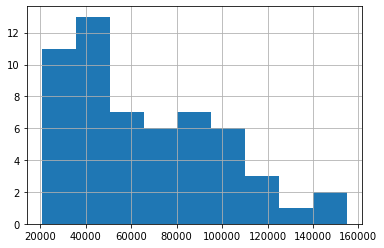

X


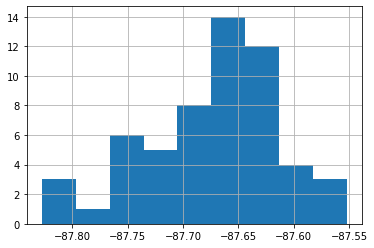

Y


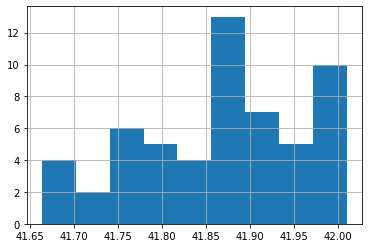

Civic Services


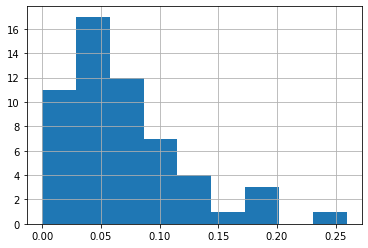

Leisure


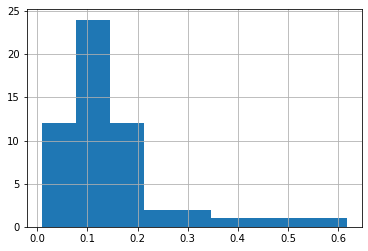

Offices


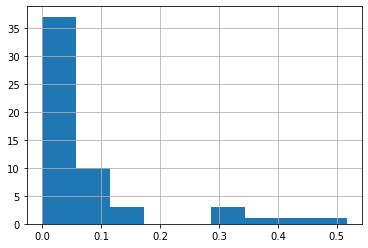

Other Landuses


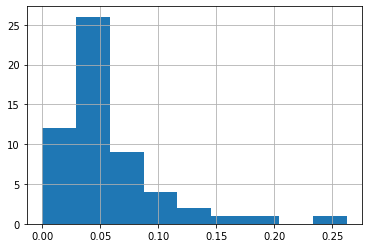

Professional Services


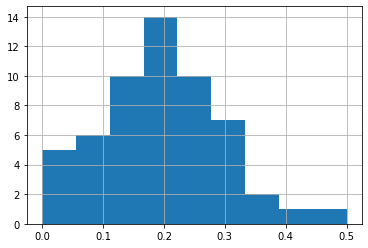

Restaurants


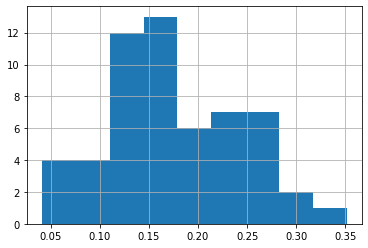

Retails


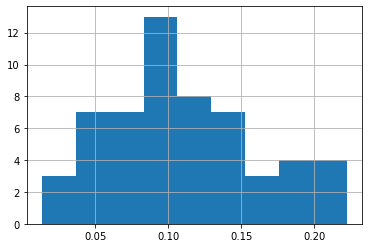

Schools


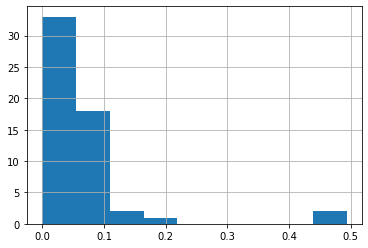

Sport and Fitness


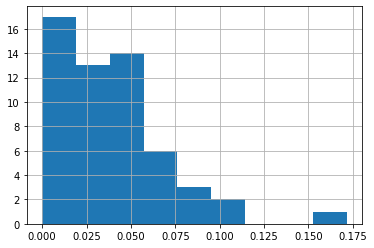

Transportation


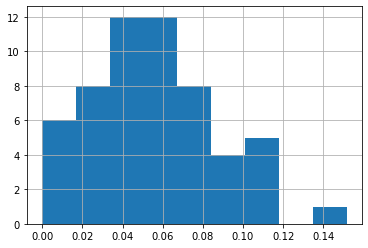

In [22]:
for var in df_clusters.columns:
    print (var)
    df_clusters[var].hist(bins=9)
    plt.show()

### Clustering Analysis 
This study deploys the k-means clustering analysis to identify the typologies of Chicago neighborhoods. This approach aims to partition n observations into k clusters based on input variables. All observations belonging to the same cluster have the nearest mean distances (to the cluster centroid). Numerically, k-means clustering minimizes within-cluster variances and optimizes squared errors. At the same time, the key challenge for implementing k-means clustering is to determine the optimal k – the number of clusters. This study, therefore, computes silhouette scores for each k option to find the best partitioning result. 

As described in the previous section, the complete dataset consists of 13 variables for clustering analysis (Table 1). However, their ranges and variances differ greatly, and these variables need to be standardized before implementing the clustering algorithm. Also, this study involves geometric variables (i.e., latitude and longitude) for clustering. This is because the spatial spillover appears in urban neighborhoods where nearby communities are more like to share the similarities. Therefore, identifying the spatial clusters is helpful for effective strategic planning. 

Then, the exploratory analysis compares the characteristics of identified neighborhood typologies/clusters. This study compares the means and standard errors of the mean across the clusters. The results illustrate the social disparities and explore the reasons behind the facts, seeking actionable improvements for underdeveloped urban neighborhoods.  


      ZP_INC          X          Y  Civic Services   Leisure   Offices  \
0  107195.42 -87.622064  41.885285        0.032787  0.114754  0.516393   
1  147682.05 -87.629148  41.883073        0.084746  0.093220  0.305085   
2  154786.84 -87.625510  41.880188        0.036364  0.090909  0.290909   

   Other Landuses  Professional Services  Restaurants   Retails   Schools  \
0        0.065574               0.065574     0.073770  0.065574  0.000000   
1        0.050847               0.169492     0.118644  0.084746  0.008475   
2        0.063636               0.100000     0.109091  0.100000  0.118182   

   Sport and Fitness  Transportation  
0           0.032787        0.016393  
1           0.016949        0.067797  
2           0.045455        0.036364  


<function matplotlib.pyplot.show(close=None, block=None)>

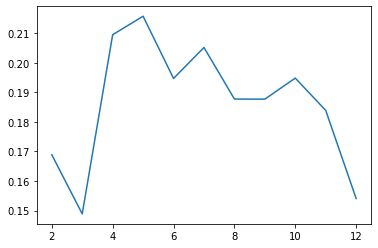

In [14]:
# Cluster zipcode
# Identify clusters based on spatial & income
df_clusters = gdf_chicago[['SPATIAL_ID','ZP_INC', 'X', 'Y']].merge(zpcd_grouped, left_on ='SPATIAL_ID', right_on = 'ZPCD')
df_clusters = df_clusters.drop(['SPATIAL_ID','ZPCD'],1)
print(df_clusters.head(3))

# Standarize values for clustering
st_clusters = StandardScaler().fit_transform(df_clusters)
# print(st_clusters)

# ------------------------------------
# Identify cluster using K-mean
k_max = 12
silho = []
for k in range(2, k_max+1):
    # print('Testing k: ', k)
    kmeans = KMeans(n_clusters = k, random_state=0).fit(st_clusters)
    labels = kmeans.labels_
    silho.append([k, silhouette_score(st_clusters, labels, metric = 'euclidean')])

# Plot SILHOUETTE SCORE
df_silho = pd.DataFrame(silho)
plt.plot(df_silho[0],df_silho[1])
plt.show
# The best k could be 5

<AxesSubplot:>

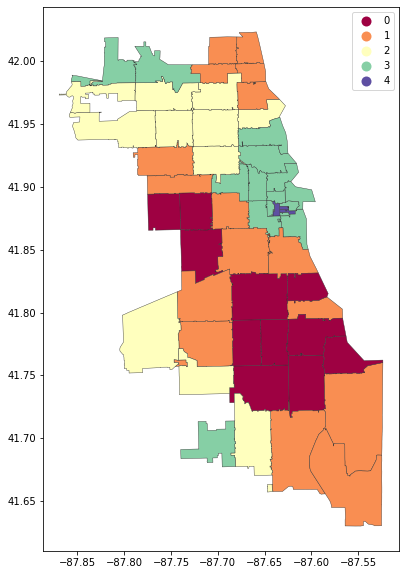

In [15]:
k_opt = 5
res_kmeans  = KMeans(n_clusters = k_opt, random_state=0).fit(df_clusters)
res_labels  = res_kmeans.labels_
res_chicago = gdf_chicago.merge(zpcd_grouped, left_on='SPATIAL_ID', right_on='ZPCD')
res_chicago['CLUSTER_ID'] = res_labels

res_sorting = res_chicago[['CLUSTER_ID','INCOME']].groupby('CLUSTER_ID').agg(np.mean)
res_sorted  = res_sorting.sort_values('INCOME').reset_index()
res_sorted['LABELS'] = res_sorted.index
res_reorder = res_sorted[['CLUSTER_ID','LABELS']]

fin_chicago = res_chicago.merge(res_reorder, how = 'left', on = 'CLUSTER_ID')

# fin_chicago.head(5)
fin_chicago.plot(
    column = 'LABELS', categorical=True, cmap='Spectral',
    figsize = [20,10], linewidth=.4, edgecolor='0.2',
    legend=True)

### Exploratory Analysis

Clustering the neighborhoods is not intended to label the area with “good” or “bad”; rather, clustering analysis helps to visualize the social disparities, explore the underlying reasons, and probably identify strategies for improvements. 

It compares the characteristics of neighborhood clusters. As mentioned before, Group 4 is unique, especially regarding its land uses. On average, over 30% of venues within the neighborhoods are offices or co-worker places. Hence, other categories, such as Restaurants, Leisure (e.g., parks) are significantly lower in terms of the proposition.

<ipython-input-23-b4f6ef150120>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fin_tab['sem'] = 1.96*fin_tab['std']/(fin_tab['size']**0.5)


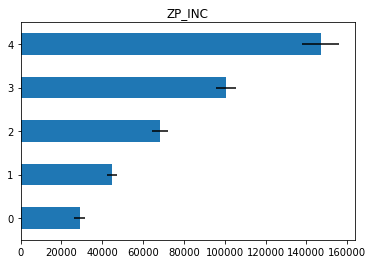

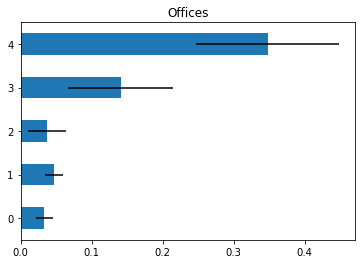

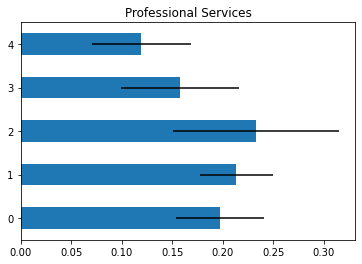

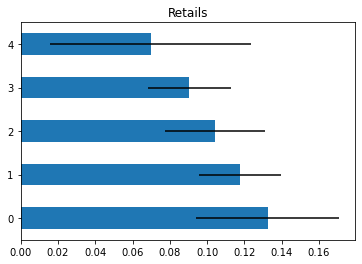

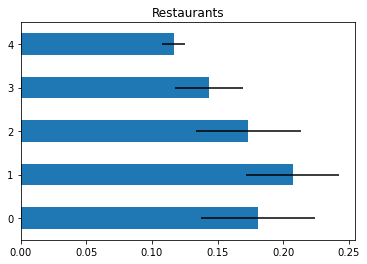

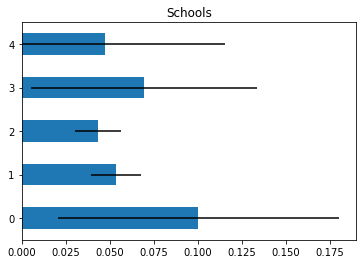

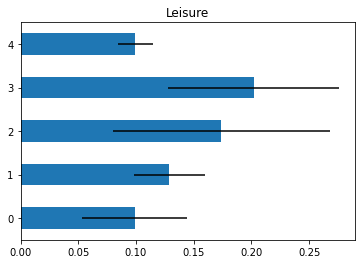

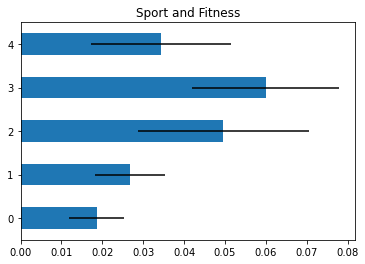

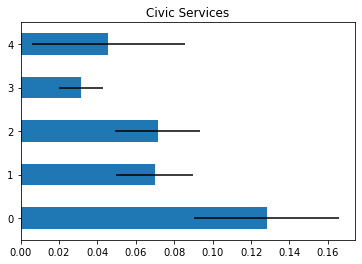

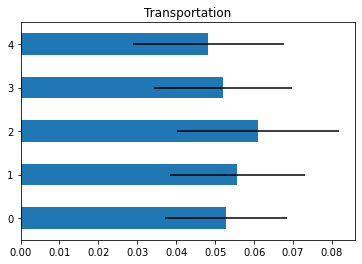

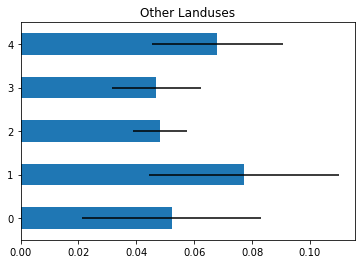

In [23]:
fin_summary = fin_chicago.groupby('LABELS').agg([np.mean, np.std, np.size])
fin_sum_srt = fin_summary.sort_values(('ZP_INC','mean')).reset_index()

vars_list = ['ZP_INC', 'Offices', 'Professional Services', 'Retails', 'Restaurants', 'Schools',
             'Leisure', 'Sport and Fitness', 'Civic Services', 'Transportation', 'Other Landuses']

for col in vars_list:
    fin_tab = fin_sum_srt[col]
    fin_tab['sem'] = 1.96*fin_tab['std']/(fin_tab['size']**0.5)
    fin_tab.plot(kind = "barh", y = "mean", legend = False, xerr = "sem", title = col)
    plt.xlim(xmin=0)

## CONCLUSION

This study collects data and identifies the typologies of Chicago neighborhoods based on socioeconomic factors and built environment features. All neighborhoods are then categorized into five groups. The results show that: 

• the income disparities are also associated with varying numbers of infrastructure and services in the neighborhood,

• the sport and fitness venues, such as basketball courts and activity centers, are notably lacking in low-income neighborhoods,

• leisure places, such as parks, are also fewer in the historically disadvantaged area

The results suggest public and private investments pay more attention to these areas. Strategic planning and capital investments could narrow the gaps among neighborhoods and improve the quality of life for all urbanites.  

